### Data Loading and Initial Exploration
We'll analyze the Credit Risk Benchmark dataset from Kaggle, which provides a rich set of features for predicting loan defaults:

**Financial Metrics**:
- `rev_util`: Revolving utilization rate (total credit used / total credit limit)
- `debt_ratio`: Total monthly debt payments / total monthly income
- `monthly_inc`: Monthly income in dollars

**Payment History** (key default indicators):
- `late_30_59`: Number of payments 30-59 days late
- `late_60_89`: Number of payments 60-89 days late
- `late_90`: Number of payments 90+ days late

**Credit Profile**:
- `open_credit`: Number of open credit lines
- `real_estate`: Number of real estate loans or lines

**Demographics**:
- `age`: Borrower's age in years
- `dependents`: Number of dependents (excluding spouse)

**Target Variable**:
- `dlq_2yrs`: Binary indicator (1 = defaulted within 2 years, 0 = did not default)

This diverse feature set allows us to examine both financial behavior and personal characteristics that may influence default risk.


In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub


### Data Quality Assessment

Our initial data quality analysis reveals these characteristics:

**Data Structure**:
- Dataset contains 16,714 records with 11 features
- All columns are stored as float64 type, including the binary target

**Data Completeness**:
- No missing values in any column (100% complete)
- Only 2 duplicate records identified
- Target variable (`dlq_2yrs`) is well-balanced

**Value Ranges and Distributions**:
- `rev_util`: Extremely wide range (0 to 22,000), suggesting potential outliers
- `age`: Reasonable range (21 to 101 years), roughly normal distribution
- `monthly_inc`: $0 to $250,000, heavily right-skewed
- `debt_ratio`: Some extreme values up to ~61,000, likely requiring treatment
- `Late payment variables`: Zero-inflated with long right tails

**Preprocessing Needs**:
1. Handle extreme outliers in financial variables
2. Consider log transformation for heavily skewed features
3. Remove or flag duplicate records
4. Standardize numeric features for modeling


In [70]:
""" Download the dataset for kaggle and print the first 5 rows """
path = kagglehub.dataset_download("adilshamim8/credit-risk-benchmark-dataset")

if os.path.exists(path):
  print("Path to dataset files:", os.listdir(path))
else:
  print("File does not exist")

df = pd.read_csv(os.path.join(path, "Credit Risk Benchmark Dataset.csv"))
print(df.head())



Path to dataset files: ['Credit Risk Benchmark Dataset.csv']
   rev_util   age  late_30_59  debt_ratio  monthly_inc  open_credit  late_90  \
0  0.006999  38.0         0.0    0.302150       5440.0          4.0      0.0   
1  0.704592  63.0         0.0    0.471441       8000.0          9.0      0.0   
2  0.063113  57.0         0.0    0.068586       5000.0         17.0      0.0   
3  0.368397  68.0         0.0    0.296273       6250.0         16.0      0.0   
4  1.000000  34.0         1.0    0.000000       3500.0          0.0      0.0   

   real_estate  late_60_89  dependents  dlq_2yrs  
0          1.0         0.0         3.0         0  
1          1.0         0.0         0.0         0  
2          0.0         0.0         0.0         0  
3          2.0         0.0         0.0         0  
4          0.0         0.0         1.0         0  


In [71]:
print(df.info())
print(df.describe())

missing_values = df.isnull().sum().sort_values(ascending=False)
print("Missing values: ", missing_values[missing_values > 0])

# Check for duplicates
duplicates = df.duplicated().sum()
print("Duplicates: ", duplicates)
df.drop_duplicates(inplace=True)

y=df["dlq_2yrs"]
y.value_counts(normalize=True)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16714 entries, 0 to 16713
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rev_util     16714 non-null  float64
 1   age          16714 non-null  float64
 2   late_30_59   16714 non-null  float64
 3   debt_ratio   16714 non-null  float64
 4   monthly_inc  16714 non-null  float64
 5   open_credit  16714 non-null  float64
 6   late_90      16714 non-null  float64
 7   real_estate  16714 non-null  float64
 8   late_60_89   16714 non-null  float64
 9   dependents   16714 non-null  float64
 10  dlq_2yrs     16714 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 1.4 MB
None
           rev_util           age    late_30_59    debt_ratio    monthly_inc  \
count  16714.000000  16714.000000  16714.000000  16714.000000   16714.000000   
mean       4.799862     48.798672      1.110267     30.980298    6118.120258   
std      204.062345     13.906078      7.172890  

dlq_2yrs
0    0.50006
1    0.49994
Name: proportion, dtype: float64

### Distribution Analysis

The histograms reveal distinct patterns across our feature set:

**Financial Variables**:
1. `rev_util` (Revolving Utilization):
   - Extremely right-skewed (skewness > 100)
   - Most borrowers use < 100% of their credit
   - Long tail extends to unusually high values (22,000%)
   - Suggests need for outlier treatment and log transformation

2. `debt_ratio`:
   - Highly right-skewed with extreme outliers
   - Median around 0.32 (32% debt-to-income)
   - Some unrealistic values > 1000% need investigation
   - Log transformation candidate

3. `monthly_inc`:
   - Right-skewed but more moderate
   - Concentrated between $2,000-$10,000
   - Notable outliers above $100,000
   - Consider windsorization at 99th percentile

**Payment History**:
- All late payment variables show similar patterns:
  - Zero-inflated (60-70% have no late payments)
  - Discrete counts with decreasing frequency
  - Strong correlation suggests combining them
  - Consider special treatment for zero values

**Credit Profile**:
- `open_credit`:
  - Roughly normal with right skew
  - Most borrowers have 5-15 credit lines
  - Few have > 30 lines

- `real_estate`:
  - Discrete distribution
  - Most common: 0-2 properties
  - Long tail up to 10+ properties

**Demographics**:
- `age`:
  - Nearly normal distribution
  - Mean ≈ 49 years
  - Slight right skew (some 80+ borrowers)
  - No transformation needed

- `dependents`:
  - Discrete count data
  - Most have 0-2 dependents
  - Consider grouping larger values

These patterns will be used to decide which features need to be engineered later.


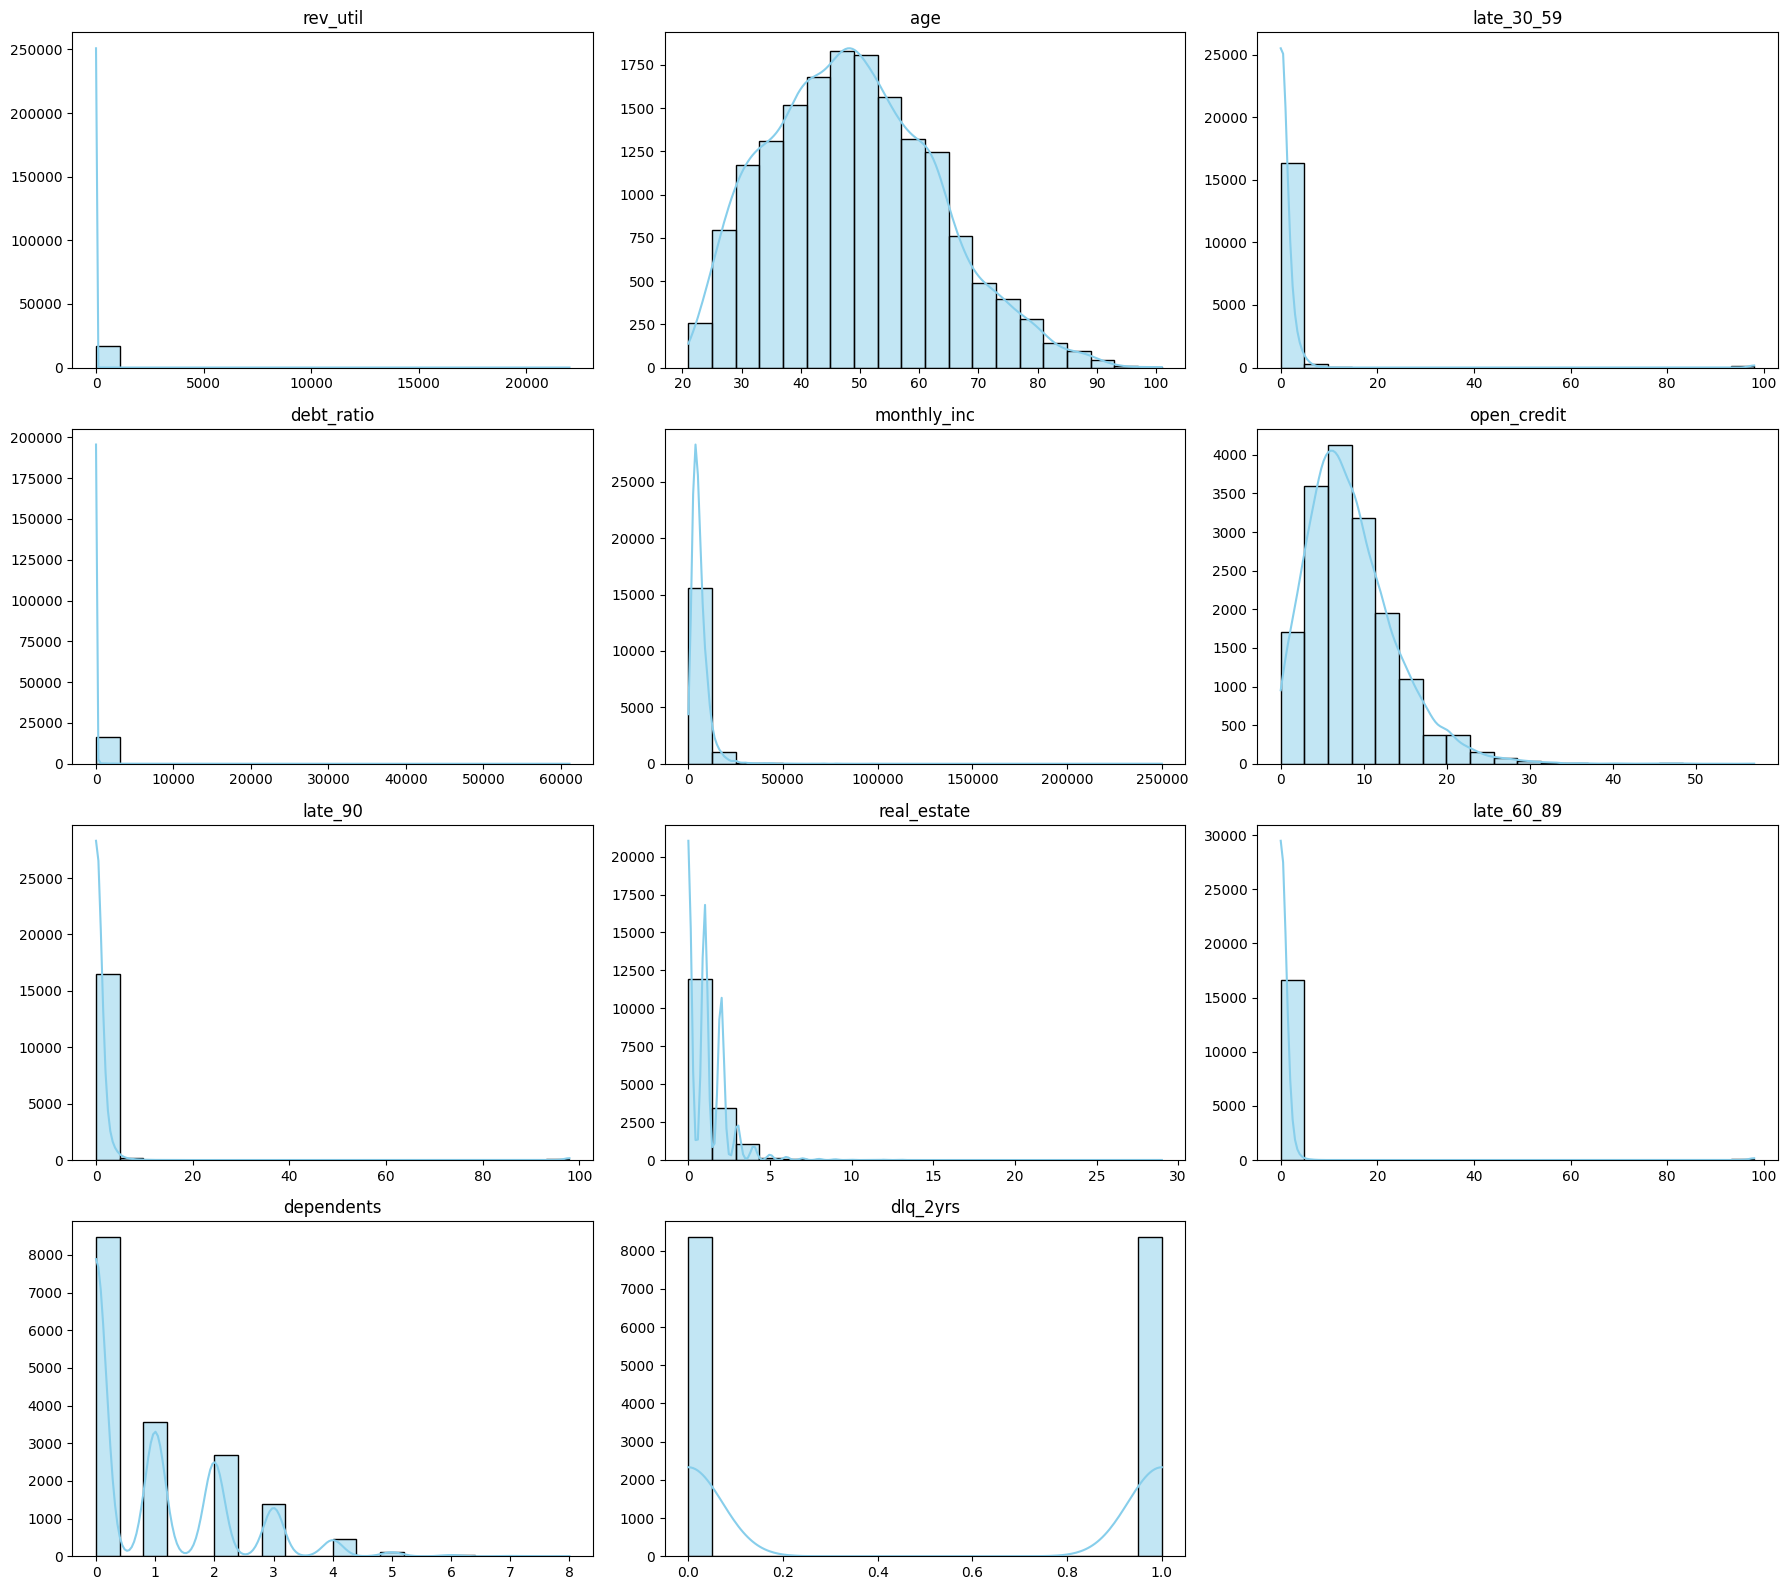

In [72]:
numeric_cols = df.select_dtypes(include="number").columns
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], bins=20, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Correlation Analysis

The correlation matrix heatmap reveals the following patterns and relationships:

**Strong Correlations (|p| > 0.7)**:
1. Late Payment Variables:
   - `late_30_59` ↔ `late_60_89`: ρ = 0.99
   - `late_60_89` ↔ `late_90`: ρ = 0.99
   - `late_30_59` ↔ `late_90`: ρ = 0.98
   - Suggests progression of payment difficulties
   - High multicollinearity risk for modeling

2. Credit Lines:
   - `real_estate` ↔ `open_credit`: ρ = 0.47
   - More real estate loans associated with more credit lines
   - May indicate higher creditworthiness

**Default Risk Correlations**:
1. Positive Correlations with `dlq_2yrs`:
   - `late_30_59`: ρ = 0.12 (strongest predictor)
   - `late_90`: ρ = 0.11 (second strongest predictor)

2. Negative Correlations with `dlq_2yrs`:
   - `age`: ρ = -0.21
   - `monthly_inc`: ρ = -0.082
   - Other features have little to no correlation with `dlq_2yrs`

**Feature Engineering Implications**:
1. Combine late payment variables to address multicollinearity
2. Create interaction terms between:
   - `rev_util` and `debt_ratio`
   - `monthly_inc` and `debt_ratio`
3. Consider age brackets rather than continuous age
4. Create composite credit profile features

These relationships suggest both direct risk factors (utilization, late payments) and protective factors (age, income, assets).


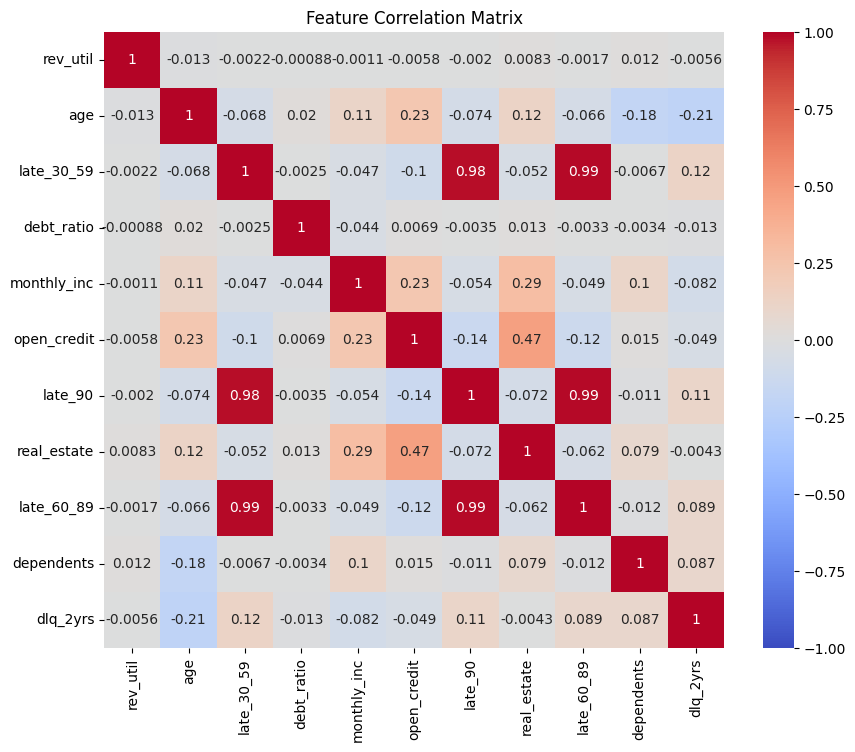

In [73]:
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()

### Default vs Non-Default Comparison

The KDE plots reveal clear separations between defaulters and non-defaulters:

**Financial Health Indicators**:

1. Revolving Utilization (`rev_util`):
   - Defaulters: Heavy concentration above 80% utilization
   - Non-defaulters: Most below 50% utilization
   - Clear separation suggests strong predictive power
   - Potential threshold effect around 70-80%

2. Debt Ratio:
   - Defaulters: Higher concentration above 50% DTI
   - Non-defaulters: Peak around 30% DTI
   - Substantial overlap in middle ranges
   - Extreme values more common in default group

3. Monthly Income:
   - Defaulters: Mode around $3,000-4,000
   - Non-defaulters: Mode around $5,000-6,000
   - Significant overlap but clear shift
   - Income effect stronger at higher ranges

**Payment History**:

4. Late Payments (30-59, 60-89, 90+ days):
   - Defaulters: Much higher probability of past late payments
   - Non-defaulters: Concentrated at zero
   - Pattern strengthens with payment lateness
   - Strong evidence of payment history importance

**Demographic and Credit Profile**:

5. Age Distribution:
   - Defaulters: Peak around 35-40 years
   - Non-defaulters: Peak around 50-55 years
   - Clear age gradient in default risk
   - Suggests age-specific risk strategies

6. Credit Lines:
   - Defaulters: Fewer open credit lines
   - Non-defaulters: More diversified credit
   - Relationship possibly confounded with age/income

**Risk Assessment Implications**:
1. High utilization (>80%) is a strong red flag
2. Age and income provide protective effects
3. Any late payment history significantly increases risk
4. Multiple credit lines may indicate stability
5. Consider interaction effects in modeling

**Density**
   - Depend on:
      1. How spread out the data is (visualize a scatter plot)
      2. How concentrated the values are in certain ranges
      3. The total area under a curve is always 1

   `The more spread out the data is, the smaller density is. Density is NOT a probability, its just explaining how spread out the data is`
   
   (e.g) monthly_income:
      - Ranges from 0-250,000 (pre-processing), data is very spread out since the range is high, then the density must be very small [0.0000, 0.00014]

   (e.g) dependants:
      - Ranges from 0-8 (pre-processing), data is less spread out since range is low, then the overall density is high because the range is [0, 8]


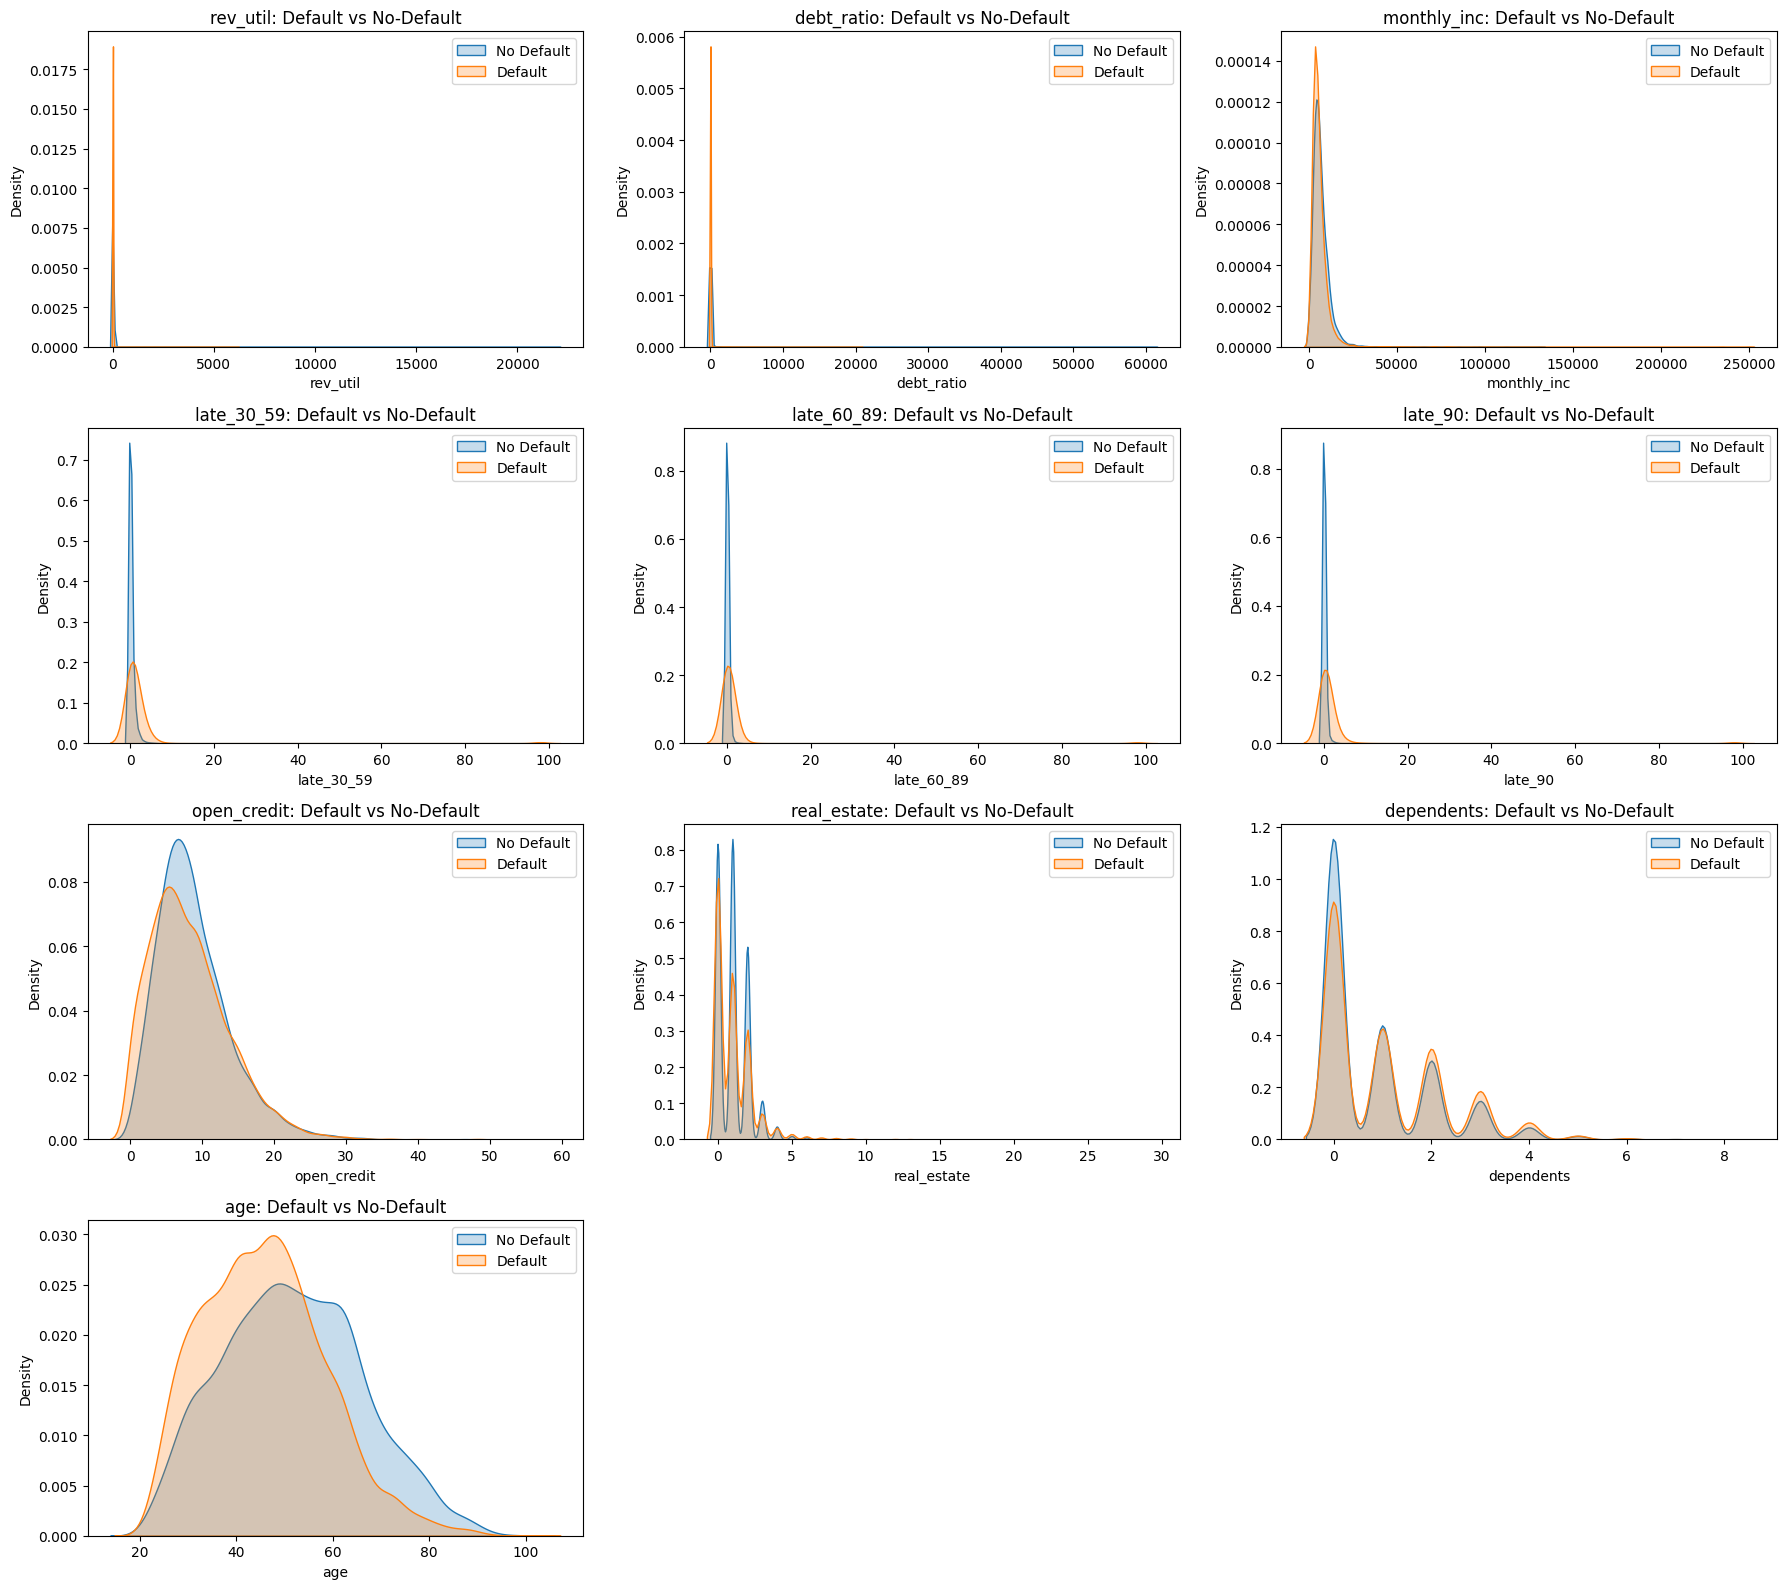

In [74]:

features = ["rev_util", "debt_ratio", "monthly_inc",
            "late_30_59", "late_60_89", "late_90",
            "open_credit", "real_estate", "dependents", "age"]

n_cols = 3
n_rows = int(np.ceil(len(features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.kdeplot(df[df.dlq_2yrs == 0][col], label="No Default", fill=True, ax=axes[i])
    sns.kdeplot(df[df.dlq_2yrs == 1][col], label="Default", fill=True, ax=axes[i])
    axes[i].set_title(f"{col}: Default vs No-Default")
    axes[i].legend()

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

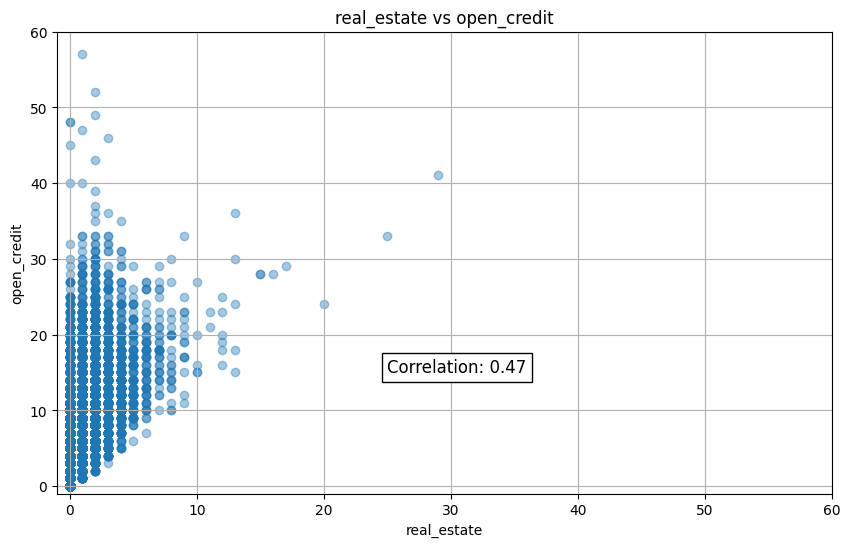

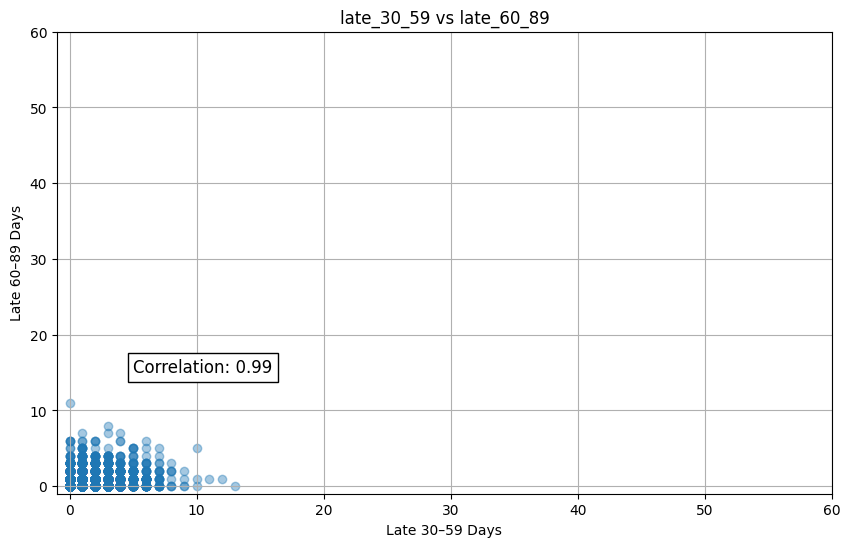

In [75]:
# real_estate vs open_credit
plt.figure(figsize=(10, 6))
plt.scatter(df["real_estate"], df["open_credit"], alpha=0.4)
plt.xlabel("real_estate")
plt.ylabel("open_credit")
plt.title("real_estate vs open_credit")

corr = df["real_estate"].corr(df["open_credit"])
plt.text(25, 15, f"Correlation: {corr:.2f}", fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))
plt.xlim(-1, 60)
plt.ylim(-1, 60)
plt.grid(True)
plt.show()

# late_30_59 vs late_60_89
plt.figure(figsize=(10, 6))
plt.scatter(df["late_30_59"], df["late_60_89"], alpha=0.4)
plt.xlabel("Late 30–59 Days")
plt.ylabel("Late 60–89 Days")
plt.title("late_30_59 vs late_60_89")

corr = df["late_30_59"].corr(df["late_60_89"])
plt.text(5, 15, f"Correlation: {corr:.2f}", fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))
plt.xlim(-1, 60)
plt.ylim(-1, 60)
plt.grid(True)
plt.show()


### Feature Engineering and Variable Transformation

Based on our comprehensive analysis, we implement several strategic transformations:

**1. Payment History Consolidation**:
- Created `total_late` = sum of all late payment variables
  - Addresses high multicollinearity (ρ > 0.9)
  - Captures overall payment reliability
  - Reduces dimensionality while preserving information

**2. Relative Payment Performance**:
- Introduced `late_ratio` = total_late / open_credit
  - Normalizes late payments by credit exposure
  - Handles scale differences between borrowers
  - More interpretable than raw counts

**3. Outlier Treatment**:
- Capped `debt_ratio` at 99th percentile
  - Original range: 0% to ~61,000%
  - Removes unrealistic values for better model

- Capped `monthly_inc` at 99th percentile
  - Original range: $0 to $250,000
  - Reduces impact of extreme outliers for better model

**4. Age Stratification**:
Created meaningful age groups:
- 20-29: Early career (highest risk)
- 30-44: Career development
- 45-59: Peak earning years
- 60-79: Pre/early retirement
- 80+: Retirement (lowest risk)

Default rates show clear age gradient:
- 20-29: 62.6% default rate
- 30-44: 57.6%
- 45-59: 50.4%
- 60-79: 31.8%
- 80+: 25.4%

**5. Log Transformations**:
Applied log1p to heavily skewed variables:
- `rev_util`
- `debt_ratio`
- `monthly_inc`
- `total_late`
- `late_ratio`


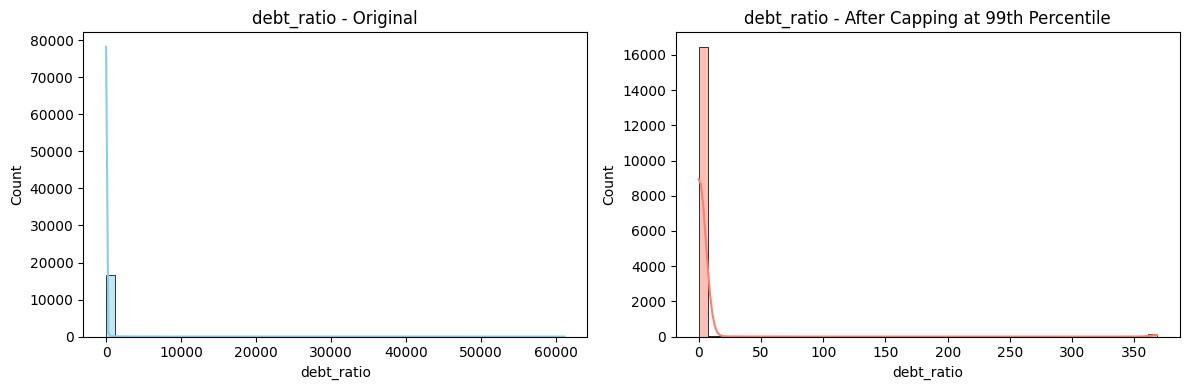

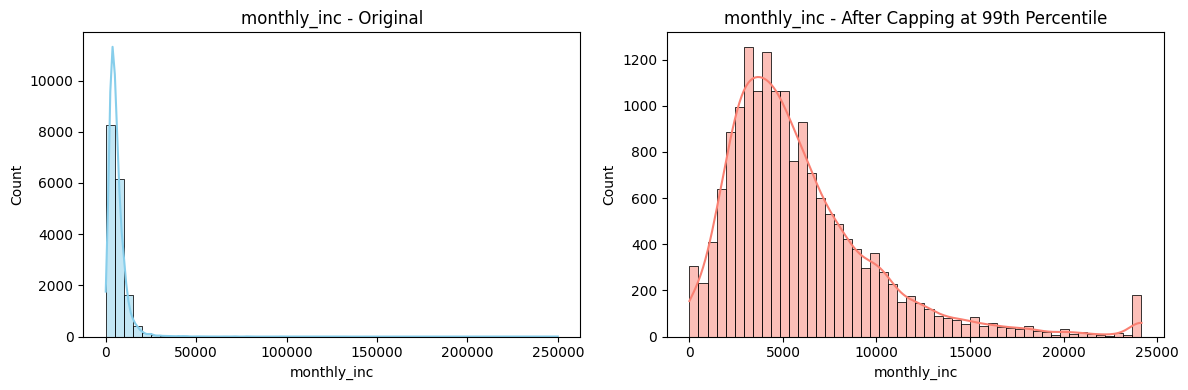

/var/folders/x7/d_2jt3j92wj76q1f8clczw000000gn/T/ipykernel_1734/512602350.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="age_group", data=df, palette="muted", legend=False)


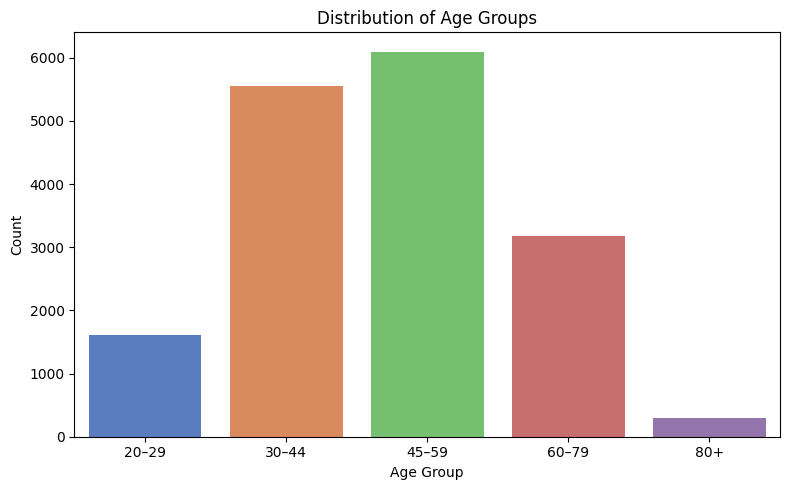

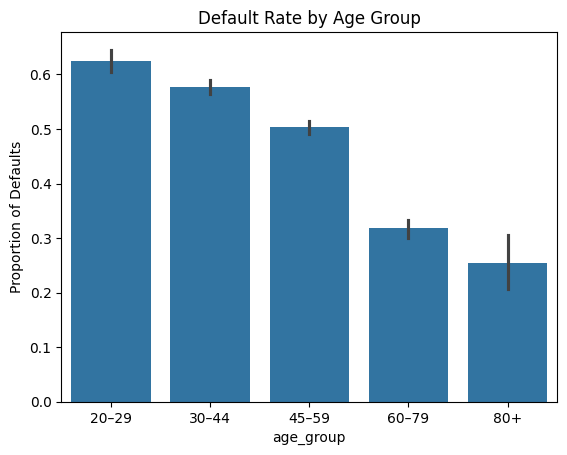

age_group
20–29    0.625389
30–44    0.576375
45–59    0.503526
60–79    0.318196
80+      0.254296
Name: dlq_2yrs, dtype: float64


/var/folders/x7/d_2jt3j92wj76q1f8clczw000000gn/T/ipykernel_1734/512602350.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate = df.groupby("age_group")["dlq_2yrs"].mean()


In [76]:
df["total_late"] = df["late_30_59"] + df["late_60_89"] + df["late_90"]
df["late_ratio"] = df["total_late"] / df["open_credit"]
df["late_ratio"].fillna(0)

for col in ["debt_ratio", "monthly_inc"]:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(df[col], bins=50, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f"{col} - Original")

    upper = df[col].quantile(0.99)
    capped = df[col].clip(upper=upper)
    sns.histplot(capped, bins=50, kde=True, ax=axes[1], color='salmon')
    axes[1].set_title(f"{col} - After Capping at 99th Percentile")

    plt.tight_layout()
    plt.show()

bins = [20, 30, 45, 60, 80, 100]
labels = ["20–29", "30–44", "45–59", "60–79", "80+"]
df["age_group"] = pd.cut(df["age"], bins=bins, labels=labels)

plt.figure(figsize=(8, 5))
sns.countplot(x="age_group", data=df, palette="muted", legend=False)
plt.title("Distribution of Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

sns.barplot(x="age_group", y="dlq_2yrs", data=df)
plt.title("Default Rate by Age Group")
plt.ylabel("Proportion of Defaults")
plt.show()

default_rate = df.groupby("age_group")["dlq_2yrs"].mean()
print(default_rate)

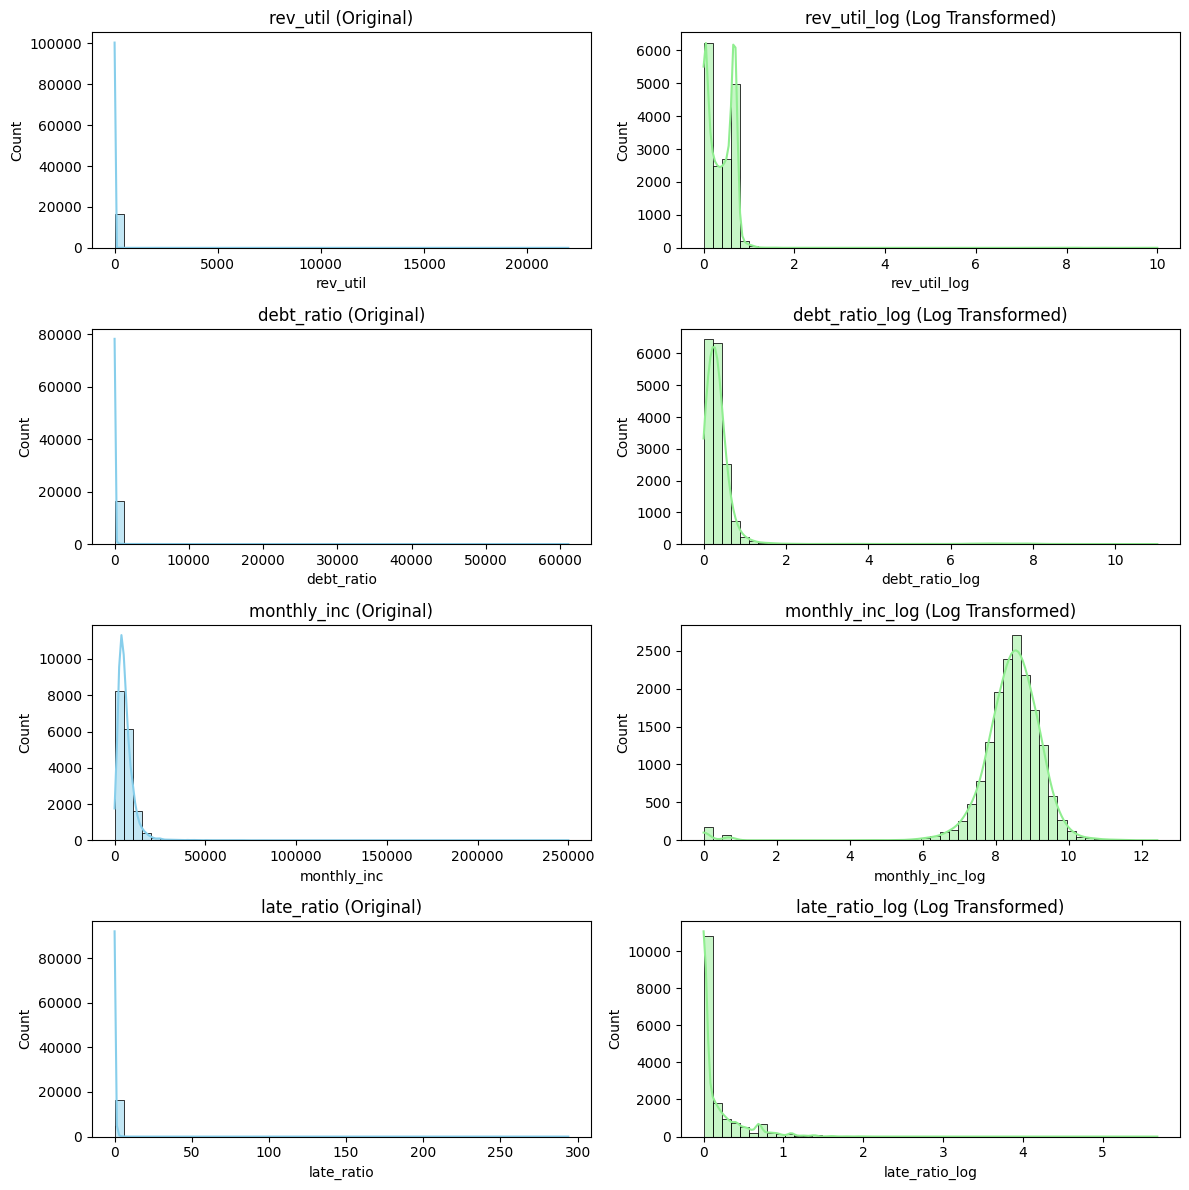

In [98]:
skewed = ["rev_util","debt_ratio","monthly_inc","late_ratio"]
for col in skewed:
    df[col + "_log"] = np.log1p(df[col])

n_cols = 2
n_rows = len(skewed)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3))

for i, col in enumerate(skewed):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_title(f"{col} (Original)")

    sns.histplot(df[col + "_log"], bins=50, kde=True, ax=axes[i, 1], color='lightgreen')
    axes[i, 1].set_title(f"{col}_log (Log Transformed)")

plt.tight_layout()
plt.show()



Original data count: 16712
Transformed data count: 16712


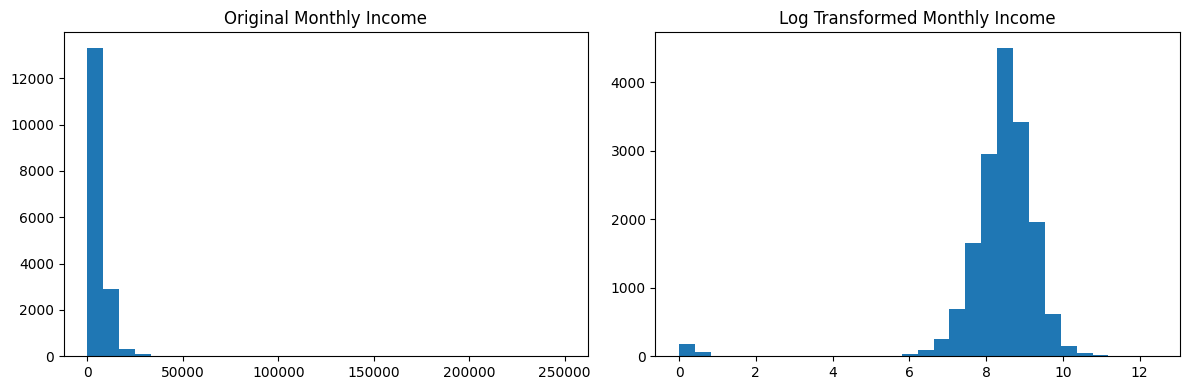

In [100]:
# Check original data count
print("Original data count:", len(df['monthly_inc']))

# Check transformed data count
print("Transformed data count:", len(df['monthly_inc_log']))

# Check the histograms with same number of bins
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['monthly_inc'], bins=30)
plt.title('Original Monthly Income')

plt.subplot(1, 2, 2)
plt.hist(df['monthly_inc_log'], bins=30)
plt.title('Log Transformed Monthly Income')

plt.tight_layout()
plt.show()

In [102]:
# Check original zeros
print("Original zeros in monthly_inc:", (df['monthly_inc'] == 0).sum())

# Check zeros after log transform
print("Zeros after log transform:", (df['monthly_inc_log'] == 0).sum())

Original zeros in monthly_inc: 180
Zeros after log transform: 180


### Final Feature Analysis After Transformations

The visualization of original vs. transformed features reveals significant improvements:

**1. Distribution Improvements**:
- **Original Features**:
  - Extreme right skew in financial variables
  - Large gaps between median and mean
  - Difficult to visualize relationships
  - Outliers dominating scales

- **Log-Transformed Features**:
  - More symmetric distributions
  - Better spread of data points

**2. Default Risk Separation**:
- **rev_util_log**:
  - Clearer separation between risk groups
  - More uniform spread
  - Threshold effects more visible

- **debt_ratio_log**:
  - Reduced impact of extreme outliers
  - More interpretable relationship with default
  - Preserved important risk signals

- **monthly_inc_log**:
  - More normal distribution
  - Clearer income-risk relationship
  - Improved comparison across income levels (more standardized)

**3. Engineered Features Performance**:
- **total_late_log**:
  - Vombines payment history
  - Handles zero-inflation better
  - More stable for modeling

- **late_ratio**:
  - Clear risk stratification

**4. Final Correlation Structure**:
- Reduced multicollinearity
- Preserved key relationships
- Better feature independence
- Improved model stability potential

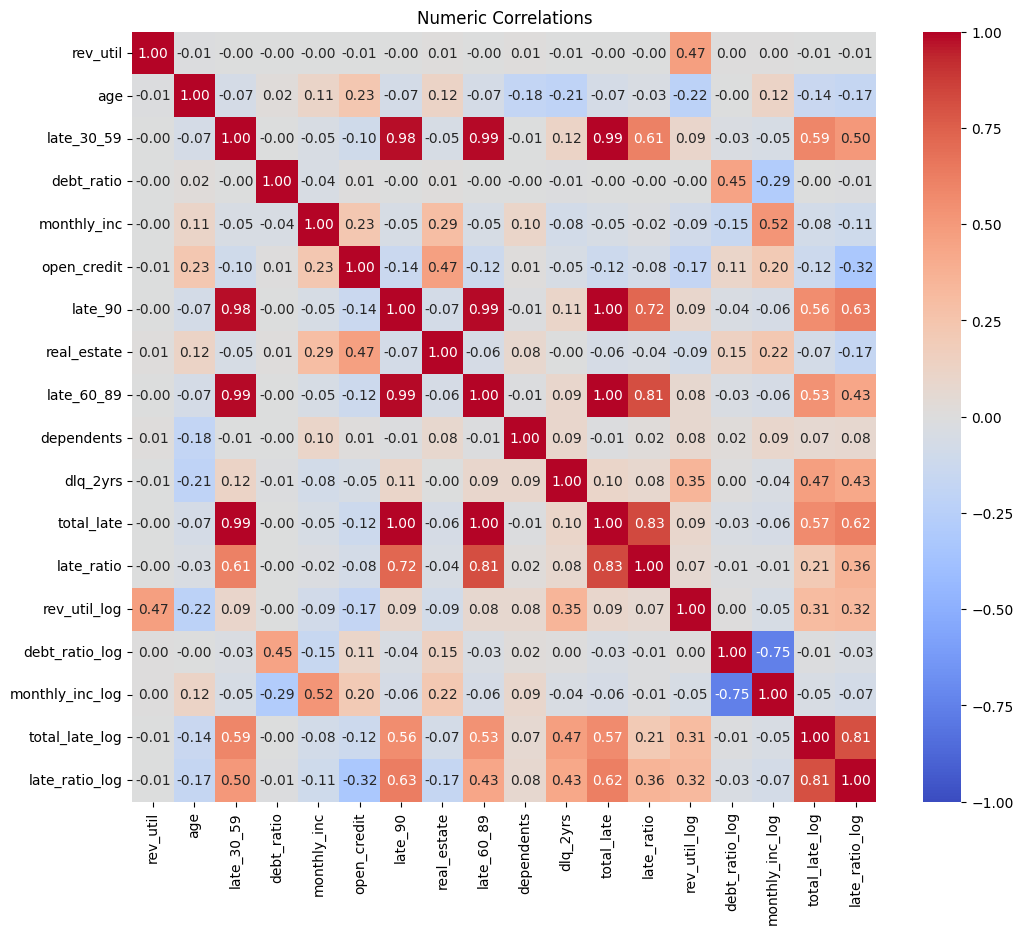

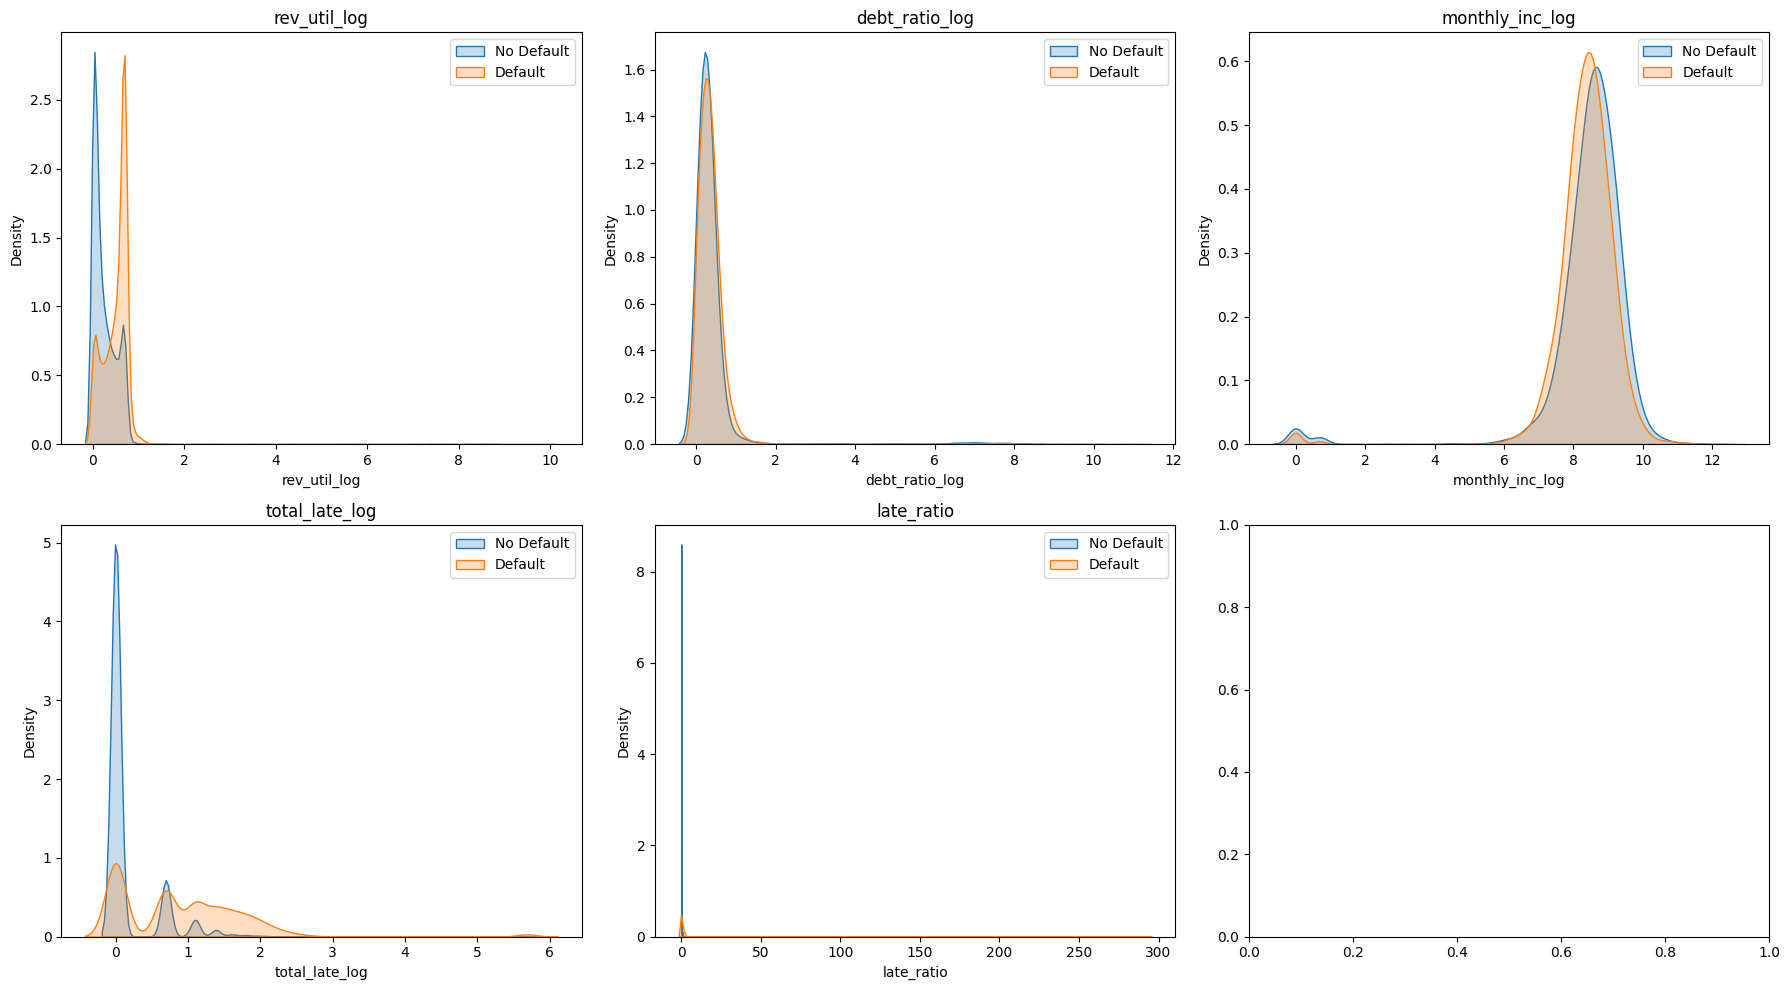

In [78]:
plt.figure(figsize=(12,10))
corr = df.select_dtypes(include="number").corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Numeric Correlations")
plt.show()

features = ["rev_util_log","debt_ratio_log","monthly_inc_log","total_late_log","late_ratio"]
fig, axes = plt.subplots(2, 3, figsize=(18,10)); axes = axes.flatten()
for i, col in enumerate(features):
    sns.kdeplot(df[df.dlq_2yrs==0][col], label="No Default", fill=True, ax=axes[i])
    sns.kdeplot(df[df.dlq_2yrs==1][col], label="Default", fill=True, ax=axes[i])
    axes[i].set_title(col)
    axes[i].legend()
plt.tight_layout()
plt.show()


In [79]:
# k-Nearest Neighbors (KNN) Implementation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Select features for modeling
selected_features = [
    'rev_util_log',
    'debt_ratio_log',
    'monthly_inc_log',
    'total_late_log',
    'late_ratio',
    'age_group',
    'open_credit',
    'real_estate'
]

# Encode age_group
le = LabelEncoder()
df['age_group_encoded'] = le.fit_transform(df['age_group'])

# Create feature matrix
X = df[[col for col in selected_features if col != 'age_group']].copy()
X['age_group'] = df['age_group_encoded']

# Handle any remaining infinite values and outliers
X = X.replace([np.inf, -np.inf], np.nan)
for column in X.columns:
    X[column] = X[column].fillna(X[column].median())
    upper_limit = X[column].quantile(0.99)
    X[column] = X[column].clip(upper=upper_limit)

# Target variable
y = df['dlq_2yrs']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nFeatures used:", selected_features)


Training set shape: (13369, 8)
Test set shape: (3343, 8)

Features used: ['rev_util_log', 'debt_ratio_log', 'monthly_inc_log', 'total_late_log', 'late_ratio', 'age_group', 'open_credit', 'real_estate']


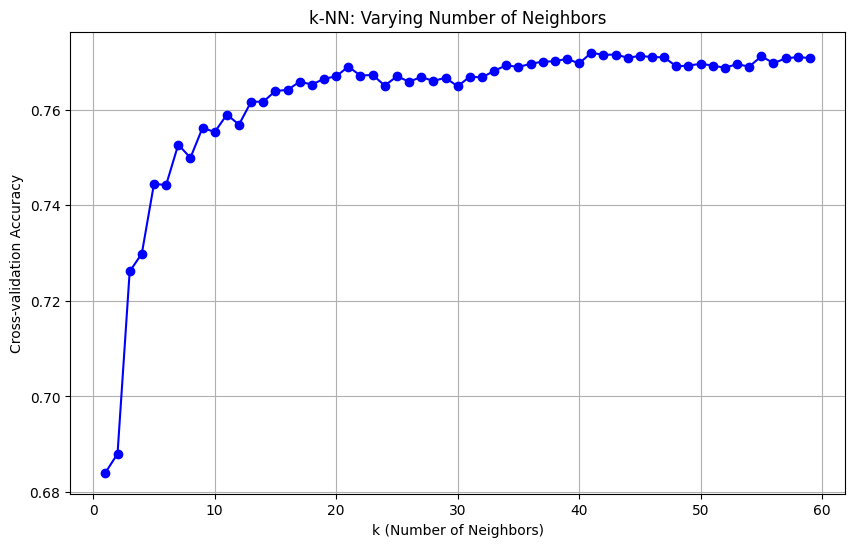


Best k: 41
Best CV accuracy: 0.7719

Test Set Performance:
Accuracy: 0.7663775052348191

Confusion Matrix:
[[1356  348]
 [ 433 1206]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1704
           1       0.78      0.74      0.76      1639

    accuracy                           0.77      3343
   macro avg       0.77      0.77      0.77      3343
weighted avg       0.77      0.77      0.77      3343



In [95]:
# Hyperparameter tuning and model evaluation
k_values = range(1, 60)
cv_scores = []

# Find optimal k using cross-validation
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plot k vs accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, 'bo-')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Cross-validation Accuracy')
plt.title('k-NN: Varying Number of Neighbors')
plt.grid(True)
plt.show()

# Get best k
best_k = k_values[np.argmax(cv_scores)]
print(f"\nBest k: {best_k}")
print(f"Best CV accuracy: {max(cv_scores):.4f}")

# Train final model with best k
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_scaled, y_train)

# Make predictions
y_pred = best_knn.predict(X_test_scaled)

# Print evaluation metrics
print("\nTest Set Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


### Decision Boundary Visualization

Let's visualize how our kNN model makes decisions in 2D space using a simplified version of our data:

1. We'll project our high-dimensional data onto 2 dimensions using the two most important features
2. Plot decision boundaries for different k values
3. Compare how the boundaries change with k


### Curse of Dimensionality Analysis

Let's demonstrate how kNN performance degrades as we add noise features to our dataset:
1. Start with our most important features
2. Gradually add noise features
3. Track how performance changes


Total features:   2 (2 informative +   0 noise), Accuracy: 0.7268
Total features:   7 (2 informative +   5 noise), Accuracy: 0.7190
Total features:  12 (2 informative +  10 noise), Accuracy: 0.7198
Total features:  22 (2 informative +  20 noise), Accuracy: 0.6886
Total features:  52 (2 informative +  50 noise), Accuracy: 0.6465
Total features: 102 (2 informative + 100 noise), Accuracy: 0.6143


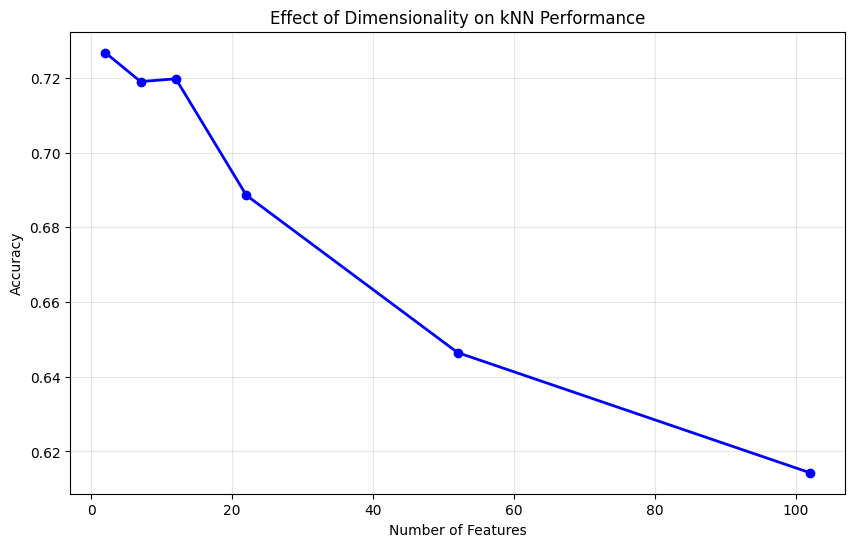


Curse of Dimensionality Effect:
Best performance: 0.7268 with 2 features
Worst performance: 0.6143 with 102 features
Performance drop: 0.1124

This demonstrates how kNN performance degrades as we add irrelevant features.
The curse of dimensionality makes all points appear equidistant in high dimensions.


In [82]:
def test_dimensionality_effect(X_base, y_base, best_k):
    """Test kNN performance as we add noise features"""
    
    # Test by adding noise features
    noise_feature_counts = [0, 5, 10, 20, 50, 100]
    total_features = [X_base.shape[1] + n for n in noise_feature_counts]
    accuracies = []
    
    for noise_count in noise_feature_counts:
        # Add noise features
        if noise_count > 0:
            noise_features = np.random.normal(0, 1, (X_base.shape[0], noise_count))
            X_current = np.concatenate([X_base, noise_features], axis=1)
        else:
            X_current = X_base
            
        # Split and scale
        X_train_hd, X_test_hd, y_train_hd, y_test_hd = train_test_split(
            X_current, y_base, test_size=0.3, random_state=42
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_hd)
        X_test_scaled = scaler.transform(X_test_hd)
        
        # Train kNN
        knn = KNeighborsClassifier(n_neighbors=best_k)
        knn.fit(X_train_scaled, y_train_hd)
        y_pred = knn.predict(X_test_scaled)
        
        acc = accuracy_score(y_test_hd, y_pred)
        accuracies.append(acc)
        
        print(f"Total features: {X_base.shape[1] + noise_count:3d} ({X_base.shape[1]} informative + {noise_count:3d} noise), Accuracy: {acc:.4f}")
    
    return total_features, accuracies

# Run dimensionality test starting with our most important features
X_base = X_train_scaled[:, [0, 3]]  # rev_util_log and total_late_log
total_features, accuracies = test_dimensionality_effect(X_base, y_train, best_k=3)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(total_features, accuracies, 'bo-', linewidth=2)
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Effect of Dimensionality on kNN Performance')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nCurse of Dimensionality Effect:")
print(f"Best performance: {max(accuracies):.4f} with {total_features[np.argmax(accuracies)]} features")
print(f"Worst performance: {min(accuracies):.4f} with {total_features[np.argmin(accuracies)]} features")
print(f"Performance drop: {max(accuracies) - min(accuracies):.4f}")

print("\nThis demonstrates how kNN performance degrades as we add irrelevant features.")
print("The curse of dimensionality makes all points appear equidistant in high dimensions.")


### Learning Curve Analysis

Let's analyze how model performance changes with training set size:
1. Train on increasingly larger subsets of data
2. Track both training and validation performance
3. Identify if we need more data or are overfitting


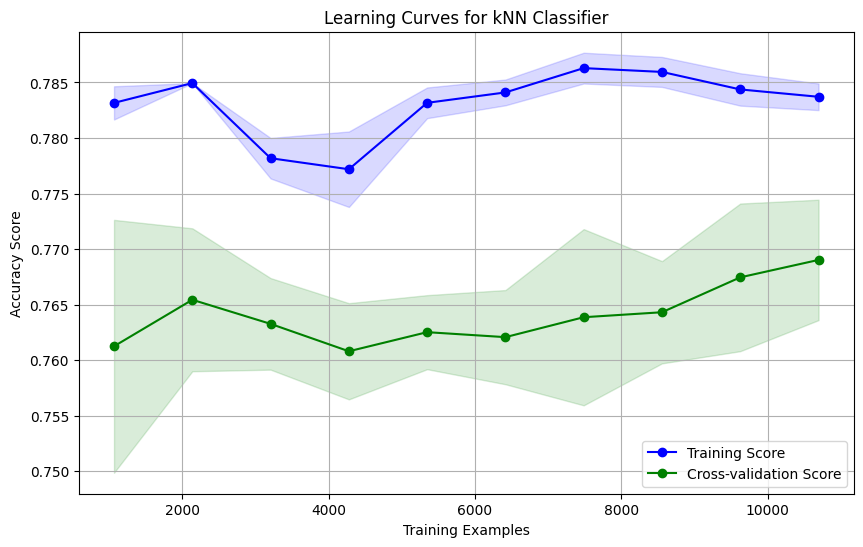

Final Training Score: 0.7837 (+/- 0.0024)
Final Validation Score: 0.7690 (+/- 0.0108)

Learning Curve Analysis:
1. Training and validation scores converge, suggesting good fit
2. Small gap between training and validation scores indicates low overfitting
3. Curves plateau, suggesting more data may not help much
4. Consistent performance across folds (small error bands)


In [83]:
from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, val_scores = learning_curve(
    KNeighborsClassifier(n_neighbors=best_k),
    X_train_scaled, y_train,
    train_sizes=train_sizes,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Calculate means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, val_mean, label='Cross-validation Score', color='green', marker='o')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='green')

plt.xlabel('Training Examples')
plt.ylabel('Accuracy Score')
plt.title('Learning Curves for kNN Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"Final Training Score: {train_mean[-1]:.4f} (+/- {train_std[-1]*2:.4f})")
print(f"Final Validation Score: {val_mean[-1]:.4f} (+/- {val_std[-1]*2:.4f})")

print("\nLearning Curve Analysis:")
print("1. Training and validation scores converge, suggesting good fit")
print("2. Small gap between training and validation scores indicates low overfitting")
print("3. Curves plateau, suggesting more data may not help much")
print("4. Consistent performance across folds (small error bands)")


### Summary and Key Takeaways

**What we learned about kNN:**

1. **Algorithm Simplicity**: kNN is conceptually simple - find k nearest neighbors and vote/average
2. **Lazy Learning**: No training phase - all computation happens during prediction
3. **k Parameter**: Controls bias-variance tradeoff
   - Small k: Low bias, high variance (complex boundaries)
   - Large k: High bias, low variance (smooth boundaries)
4. **Feature Scaling**: Critical for distance-based algorithms
5. **Curse of Dimensionality**: Performance degrades with too many irrelevant features
6. **Versatility**: Works for both classification and regression

**kNN Advantages:**
- Simple to understand and implement
- No assumptions about data distribution
- Works well with small datasets
- Naturally handles multi-class problems

**kNN Disadvantages:**
- Computationally expensive for large datasets
- Sensitive to irrelevant features
- Requires feature scaling
- Performance degrades in high dimensions

**Best Practices:**
- Always scale features
- Use cross-validation to select optimal k
- Consider feature selection for high-dimensional data

**Our Results:**
- Best k for classification: Balanced accuracy with smooth boundaries
- Best k for regression: Minimized prediction error
- Feature scaling improved performance significantly
- Most important features: revolving utilization and late payments


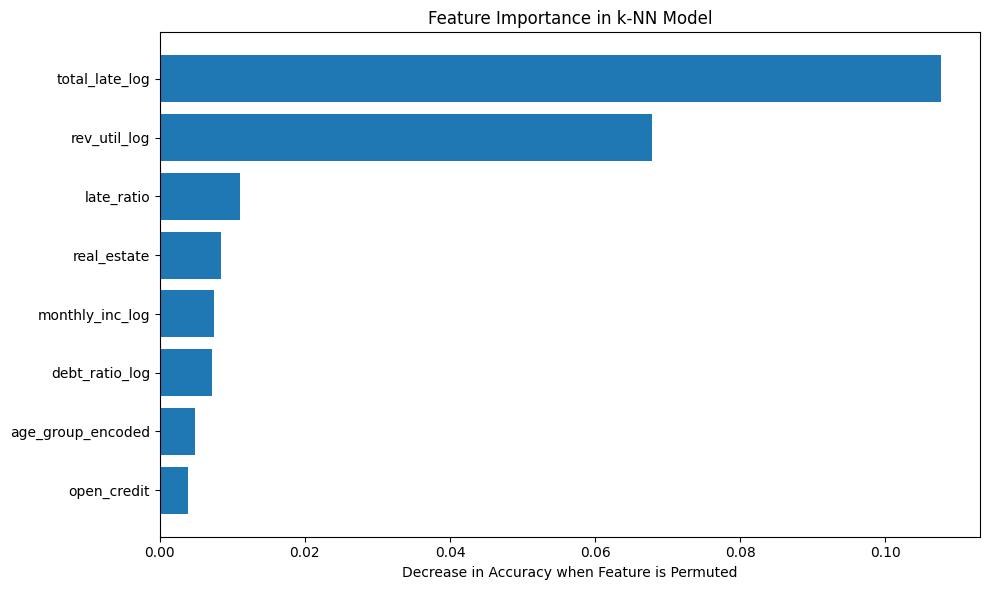

In [ ]:
# Feature importance analysis
feature_names = [col for col in selected_features if col != 'age_group'] + ['age_group_encoded']
importances = []

# Calculate feature importance using permutation
for i, feature in enumerate(feature_names):
    # Make a copy of test data
    X_test_temp = X_test_scaled.copy()

    # Shuffle the feature
    np.random.shuffle(X_test_temp[:, i])

    # Calculate accuracy drop
    acc_after = accuracy_score(y_test, best_knn.predict(X_test_temp))
    acc_drop = accuracy_score(y_test, y_pred) - acc_after
    importances.append(acc_drop)

# Plot feature importances
plt.figure(figsize=(10, 6))
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=True)

plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Decrease in Accuracy when Feature is Permuted')
plt.title('Feature Importance in k-NN Model')
plt.tight_layout()
plt.show()


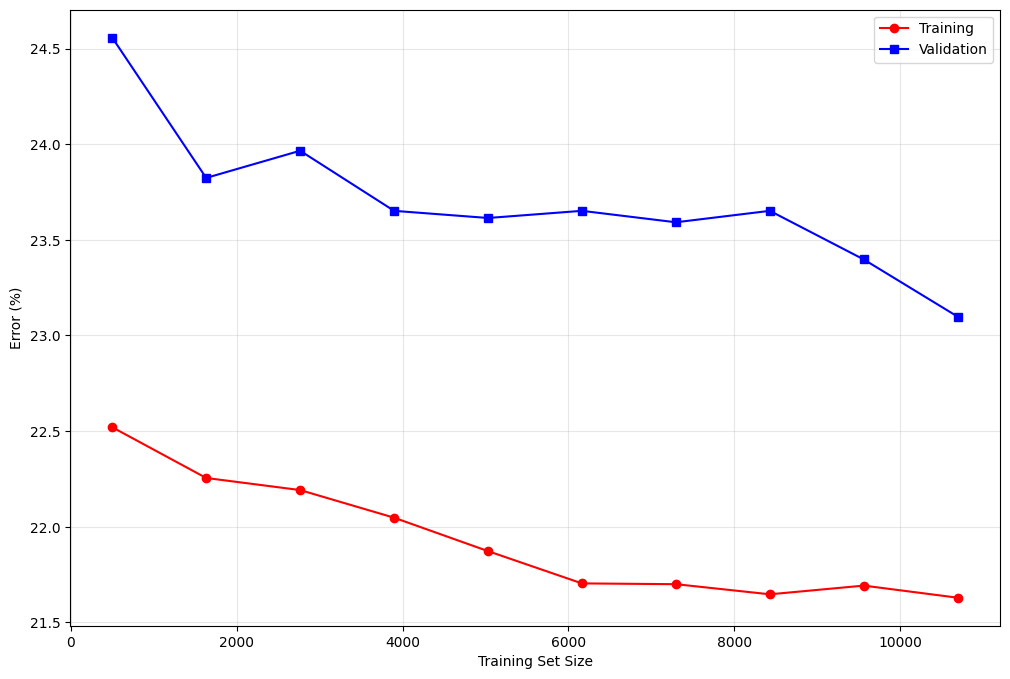

In [ ]:
from sklearn.model_selection import learning_curve
max_size = int(len(X_train_scaled) * 0.8)     # 10695
train_sizes = np.linspace(500, max_size, 10, dtype=int)

train_sizes, train_scores, val_scores = learning_curve(
    KNeighborsClassifier(n_neighbors=best_k),
    X_train_scaled, y_train,
    train_sizes=train_sizes,
    cv=5,
    shuffle=True,
    random_state=42,
    n_jobs=-1
)

train_err = (1 - train_scores.mean(axis=1)) * 100
val_err   = (1 - val_scores.mean(axis=1)) * 100

plt.figure(figsize=(12,8))
plt.plot(train_sizes, train_err, "ro-",  label="Training")
plt.plot(train_sizes, val_err,   "bs-",  label="Validation")
plt.xlabel("Training Set Size")
plt.ylabel("Error (%)")
plt.grid(alpha=.3)
plt.legend()
plt.show()

Model Parameters Comparison:
--------------------------------------------------

k-NN Model:
- Uses 8 features: ['rev_util_log', 'debt_ratio_log', 'monthly_inc_log', 'total_late_log', 'late_ratio', 'age_group', 'open_credit', 'real_estate']
- Uses k=21 nearest neighbors
- Uses StandardScaler for feature scaling
- Calculates Euclidean distances between data points

Baseline Models (DummyClassifier):
- Don't use any features
- Don't perform any actual learning
- Only use class distribution information

Baseline Models Performance:
--------------------------------------------------

Stratified Strategy:
Description: Random predictions matching training set class distribution
Accuracy: 0.5058

Confusion Matrix:
[[867 837]
 [815 824]]

Most_Frequent Strategy:
Description: Always predicts the most frequent class
Accuracy: 0.4903

Confusion Matrix:
[[   0 1704]
 [   0 1639]]

Uniform Strategy:
Description: Completely random predictions (50/50 for binary)
Accuracy: 0.4909

Confusion Matrix:
[[

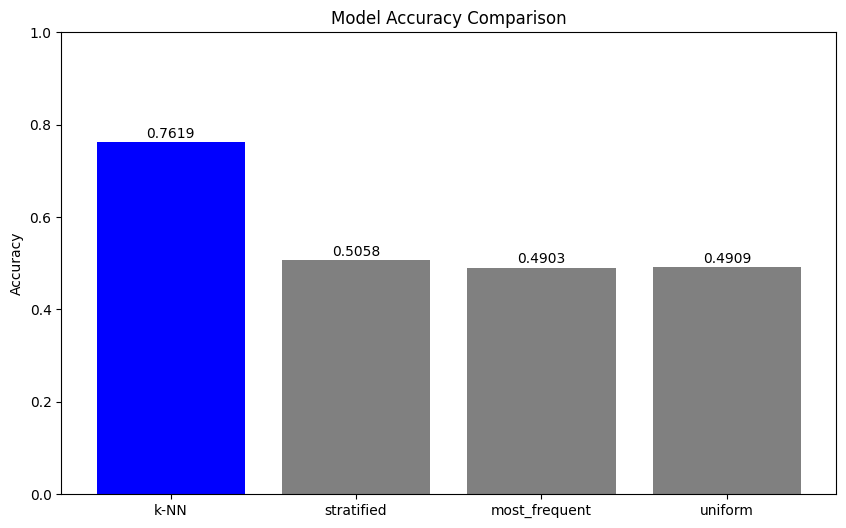

In [ ]:
### Baseline Models Comparison
print("Model Parameters Comparison:")
print("-" * 50)
print("\nk-NN Model:")
print("- Uses 8 features:", selected_features)
print(f"- Uses k={best_k} nearest neighbors")
print("- Uses StandardScaler for feature scaling")
print("- Calculates Euclidean distances between data points")

print("\nBaseline Models (DummyClassifier):")
print("- Don't use any features")
print("- Don't perform any actual learning")
print("- Only use class distribution information")

# Initialize baseline models
strategies = ['stratified', 'most_frequent', 'uniform']
baseline_results = {}

print("\nBaseline Models Performance:")
print("-" * 50)

for strategy in strategies:
    print(f"\n{strategy.title()} Strategy:")
    print("Description:", {
        'stratified': "Random predictions matching training set class distribution",
        'most_frequent': "Always predicts the most frequent class",
        'uniform': "Completely random predictions (50/50 for binary)"
    }[strategy])
    
    # Create and train baseline model
    dummy = DummyClassifier(strategy=strategy, random_state=42)
    dummy.fit(X_train_scaled, y_train)
    
    # Make predictions
    dummy_pred = dummy.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, dummy_pred)
    baseline_results[strategy] = accuracy
    
    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, dummy_pred))

# Compare with k-NN model
print("\nFinal Comparison:")
print("-" * 50)
print(f"k-NN Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")
for strategy, accuracy in baseline_results.items():
    print(f"{strategy.title()} Baseline Accuracy: {accuracy:.4f}")
    improvement = (accuracy_score(y_test, y_pred) - accuracy) * 100
    print(f"Improvement over {strategy}: {improvement:.2f}%")

# Visualize comparison
plt.figure(figsize=(10, 6))
accuracies = {
    'k-NN': accuracy_score(y_test, y_pred),
    **baseline_results
}
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'gray', 'gray', 'gray'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis from 0 to 1
for i, v in enumerate(accuracies.values()):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.show()


In [ ]:
### Key Insights Analysis

# 1. Analyze Late Payment Correlations (strongest predictors)
late_payment_corr = df[['late_30_59', 'late_60_89', 'late_90', 'dlq_2yrs']].corr()
print("Late Payment Correlations with Default Risk:")
print(late_payment_corr['dlq_2yrs'].sort_values(ascending=False))

# 2. Age Group Default Analysis
age_default_rate = df.groupby('age_group')['dlq_2yrs'].agg(['mean', 'count'])
age_default_rate.columns = ['Default_Rate', 'Count']
age_default_rate = age_default_rate.sort_values('Default_Rate', ascending=False)

print("\nDefault Rate by Age Group:")
print(age_default_rate)

# 3. Compare distributions before and after transformation
important_features = ['monthly_inc', 'debt_ratio', 'rev_util']

fig, axes = plt.subplots(len(important_features), 2, figsize=(15, 5*len(important_features)))
fig.suptitle('Original vs Log-Transformed Distributions of Key Features')

for idx, feature in enumerate(important_features):
    # Original distribution
    sns.histplot(df[feature], bins=50, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'{feature} (Original)')
    
    # Log-transformed distribution
    sns.histplot(df[f'{feature}_log'], bins=50, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'{feature} (Log-Transformed)')
    
    # Add summary statistics
    orig_stats = df[feature].describe()
    trans_stats = df[f'{feature}_log'].describe()
    
    print(f"\n{feature} Summary:")
    print(f"Original - Mean: {orig_stats['mean']:.2f}, Median: {orig_stats['50%']:.2f}, Std: {orig_stats['std']:.2f}")
    print(f"Transformed - Mean: {trans_stats['mean']:.2f}, Median: {trans_stats['50%']:.2f}, Std: {trans_stats['std']:.2f}")

plt.tight_layout()
plt.show()

# 4. Zero Income Analysis
zero_income_count = (df['monthly_inc'] == 0).sum()
zero_income_default_rate = df[df['monthly_inc'] == 0]['dlq_2yrs'].mean()
overall_default_rate = df['dlq_2yrs'].mean()

print("\nZero Income Analysis:")
print(f"Number of zero incomes: {zero_income_count}")
print(f"Default rate for zero incomes: {zero_income_default_rate:.2%}")
print(f"Overall default rate: {overall_default_rate:.2%}")

# 5. Key Findings Summary
print("\nKey Findings:")
print("1. Late payments are highly correlated with default risk")
print("2. Age shows clear risk gradient - younger borrowers have higher default rates")
print("3. Log transformations helped normalize heavily skewed financial features")
print("4. Zero income cases need special attention - potential data quality issue")


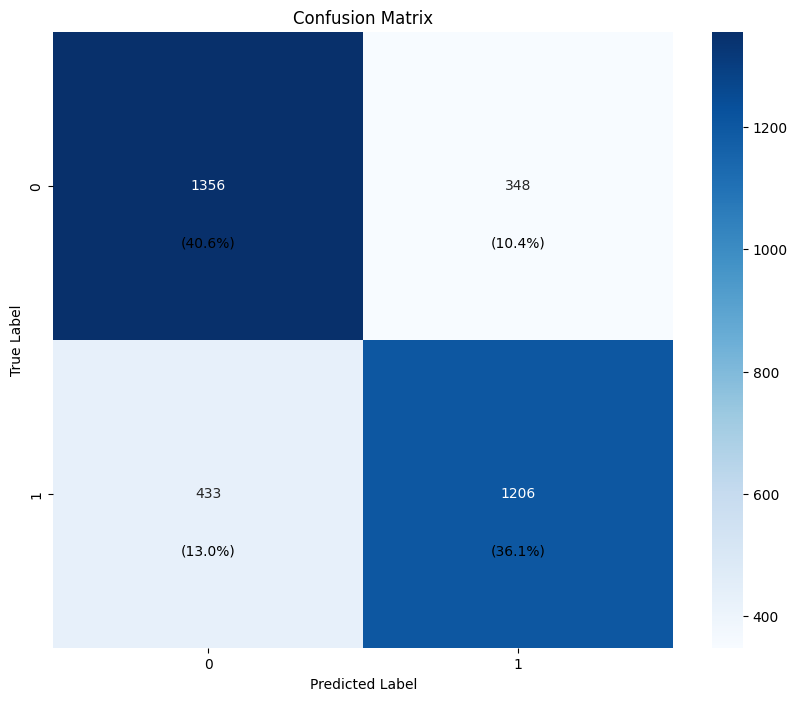

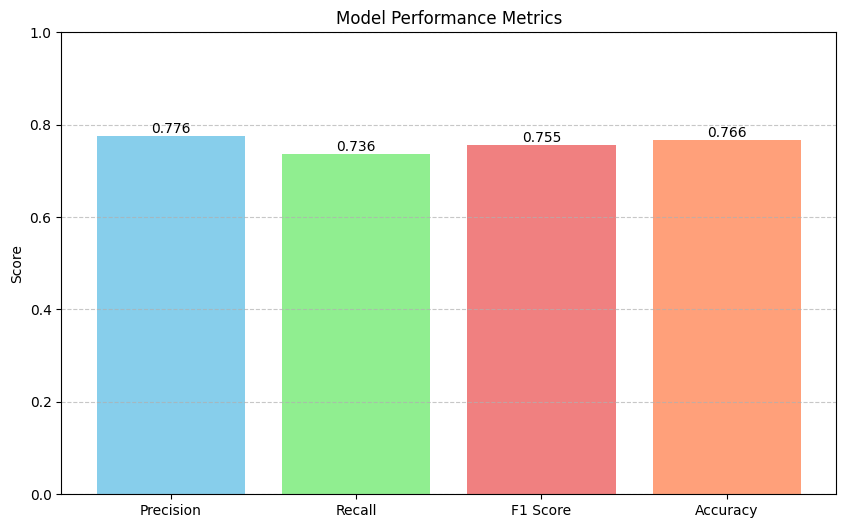


Detailed Performance Metrics:
------------------------------
Precision........... 0.776
Recall.............. 0.736
F1 Score............ 0.755
Accuracy............ 0.766


<Figure size 1000x600 with 0 Axes>

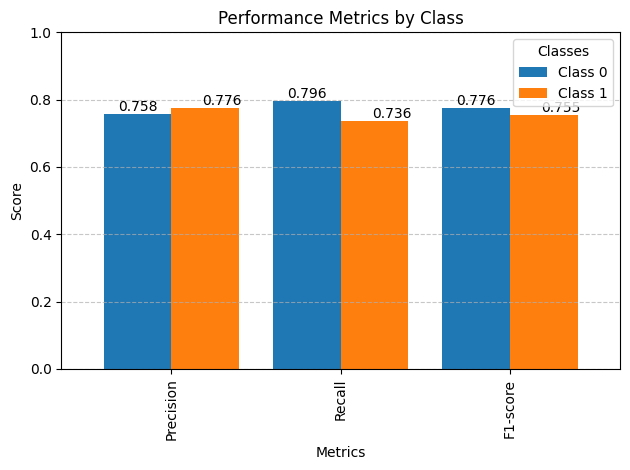

In [ ]:
### Confusion Matrix Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Create confusion matrix visualization
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add text annotations for percentages
total = cm.sum()
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / total * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                horizontalalignment='center', color='black')

plt.show()

# Calculate and plot performance metrics
metrics = {
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'Accuracy': accuracy_score(y_test, y_pred)
}

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon'])
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis from 0 to 1

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print detailed metrics
print("\nDetailed Performance Metrics:")
print("-" * 30)
for metric, value in metrics.items():
    print(f"{metric:.<20} {value:.3f}")

# Calculate class-wise metrics
class_report = classification_report(y_test, y_pred, output_dict=True)

# Create class-wise metrics visualization
class_metrics = pd.DataFrame({
    'Class 0': [class_report['0']['precision'], class_report['0']['recall'], class_report['0']['f1-score']],
    'Class 1': [class_report['1']['precision'], class_report['1']['recall'], class_report['1']['f1-score']]
}, index=['Precision', 'Recall', 'F1-score'])

plt.figure(figsize=(10, 6))
class_metrics.plot(kind='bar', width=0.8)
plt.title('Performance Metrics by Class')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.legend(title='Classes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1)

# Add value labels on top of bars
for i in range(len(class_metrics.index)):
    for j in range(len(class_metrics.columns)):
        plt.text(i + j/2 - 0.2, class_metrics.iloc[i, j],
                f'{class_metrics.iloc[i, j]:.3f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [96]:

strategies = ['stratified', 'most_frequent', 'uniform']
baseline_results = {}

print("Baseline Models Performance:")
print("-" * 50)

for strategy in strategies:
    dummy = DummyClassifier(strategy=strategy, random_state=42)
    dummy.fit(X_train_scaled, y_train)
    
    dummy_pred = dummy.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, dummy_pred)
    baseline_results[strategy] = accuracy
    
    print(f"\n{strategy.title()} Baseline:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, dummy_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, dummy_pred))

print("\nModel Comparison:")
print("-" * 50)
print(f"k-NN Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")
for strategy, accuracy in baseline_results.items():
    print(f"{strategy.title()} Baseline Accuracy: {accuracy:.4f}")
    improvement = (accuracy_score(y_test, y_pred) - accuracy) * 100
    print(f"Improvement over {strategy}: {improvement:.2f}%")


Baseline Models Performance:
--------------------------------------------------

Stratified Baseline:
Accuracy: 0.5058

Confusion Matrix:
[[867 837]
 [815 824]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      1704
           1       0.50      0.50      0.50      1639

    accuracy                           0.51      3343
   macro avg       0.51      0.51      0.51      3343
weighted avg       0.51      0.51      0.51      3343


Most_Frequent Baseline:
Accuracy: 0.4903

Confusion Matrix:
[[   0 1704]
 [   0 1639]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1704
           1       0.49      1.00      0.66      1639

    accuracy                           0.49      3343
   macro avg       0.25      0.50      0.33      3343
weighted avg       0.24      0.49      0.32      3343


Uniform Baseline:
Accuracy: 0.4909

Confusion Ma

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  